In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
mu_star = 1
s_star = 0.5

In [4]:
def logistic_loglikelihood(x, mu, s):
    z = np.exp(-(x-mu)/s)
    return np.sum( (mu - x)/s -np.log(s) - 2*np.log(1 + z))

In [5]:
n_list = [100, 1_000, 10_000]

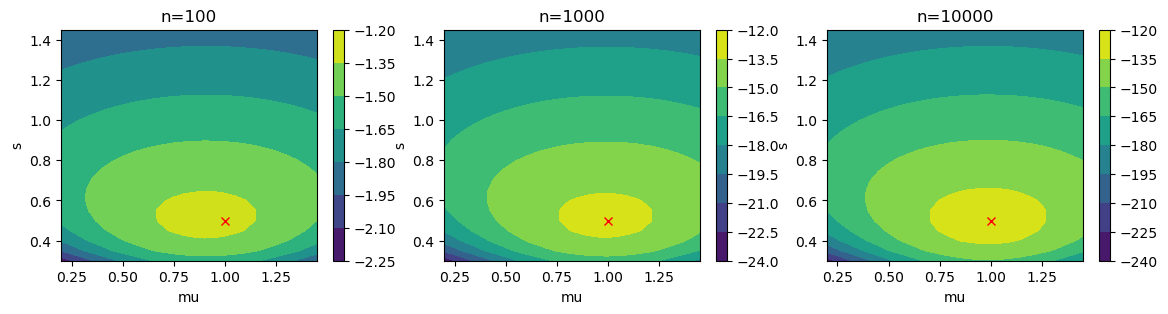

In [6]:
mu_range = np.arange(0.2, 1.5, 0.05)
s_range = np.arange(0.3, 1.5, 0.05)

datasets = []

fig, ax = plt.subplots(1, 3, figsize=(14, 3))
for idx_n, n in enumerate(n_list):

    x = np.random.logistic(mu_star, s_star, n)  # generate dataset

    loglikelihood = np.asarray([[logistic_loglikelihood(x, mu, s) for mu in mu_range] for s in s_range])
    loglikelihood /= 100  # divide loglikelihood by 100 to avoid large numbers in the colormap

    im = ax[idx_n].contourf(mu_range, s_range, loglikelihood)
    ax[idx_n].plot(mu_star, s_star, 'x', color='red')
    
    ax[idx_n].set_xlabel('mu')
    ax[idx_n].set_ylabel('s')
    ax[idx_n].set_title(f'n={n}')
    fig.colorbar(im)
    
    datasets.append(x)

plt.savefig('results/ex4b.pdf', bbox_inches='tight', pad_inches=0)
plt.draw()

----------------------
First dataset (n=100)
Estimated mu: 0.9060, Estimated s: 0.5091, MSE: 4.4597e-03
----------------------
First dataset (n=1000)
Estimated mu: 0.9853, Estimated s: 0.5077, MSE: 1.3768e-04
----------------------
First dataset (n=10000)
Estimated mu: 0.9837, Estimated s: 0.4945, MSE: 1.4733e-04
----------------------


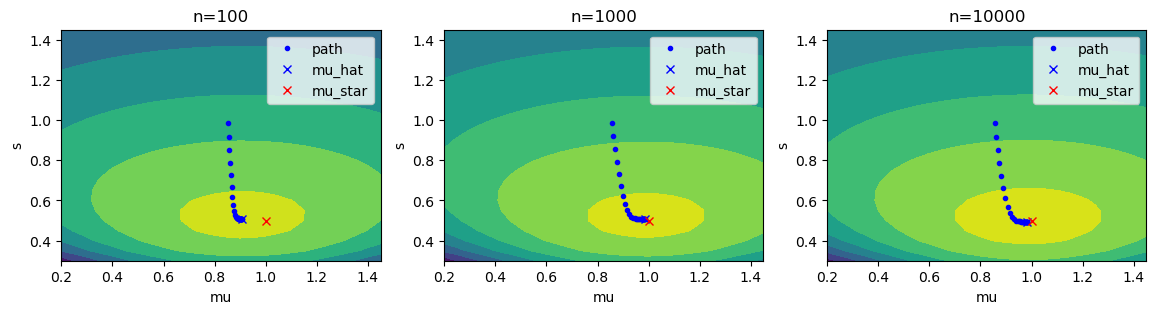

In [7]:
def compute_gradient_logistic(x, mu, s):
    n = x.shape[0]
    z = np.exp(-(x - mu)/s)
    dl_dmu = n/s - np.sum( 2*z / (s*(1+z)) )
    dl_ds = (1/s**2)*(-len(x)*(mu+s) + np.sum(x - (2*(x-mu)*z)/(1+z)) )
    return dl_dmu, dl_ds

epochs = 30  # fixed number of epochs (alternative: ascend until convergence)

mse = np.zeros(3)

mu_zero = np.random.choice(mu_range)
s_zero = np.random.choice(s_range)
param_paths = []

verbose = False
print('----------------------')
for idx_n, (x, n) in enumerate(zip(datasets,n_list)):

    lr = 1e-1/n  # learning rate (step size)

    param_path = []  # keeps track of the path of (mu, s) during the gradient ascent

    mu = mu_zero
    s = s_zero

    it = 0
    print(f'First dataset (n={n})')
    for it in range(epochs):

        dl_dmu, dl_ds = compute_gradient_logistic(x, mu, s)

        mu_old, s_old = mu, s

        # gradient ascent
        mu = mu + lr*dl_dmu
        s = s + lr*dl_ds

        param_path.append([mu, s])

        delta = .5*( (mu - mu_old)**2 + (s - s_old)**2 )  # variation at current epoch
        if verbose:
            print(f"\t Iter {it:03d}: delta {delta:.4f}")

    mse[idx_n] = .5*( (mu - mu_star)**2 + (s - s_star)**2 )
    print(f"Estimated mu: {mu:.4f}, Estimated s: {s:.4f}, MSE: {mse[idx_n]:.4e}")
    print('----------------------')
    param_path = np.asarray(param_path)
    param_paths.append(param_path)

fig, ax = plt.subplots(1, 3, figsize=(14, 3))
for idx_n, (x, n) in enumerate(zip(datasets,[100, 1_000, 10_000])):

    loglikelihood = np.asarray([[logistic_loglikelihood(x, mu, s) for mu in mu_range] for s in s_range])
    loglikelihood /= 100  # divide loglikelihood by 100 to avoid large numbers in the colormap

    param_path = param_paths[idx_n]

    ax[idx_n].contourf(mu_range, s_range, loglikelihood)
    ax[idx_n].plot(param_path[:, 0], param_path[:, 1], '.', color='blue', label='path')
    ax[idx_n].plot(param_path[-1, 0], param_path[-1, 1], 'x', color='blue', label='mu_hat')
    ax[idx_n].plot(mu_star, s_star, 'x', color='red', label='mu_star')

    ax[idx_n].set_xlabel('mu')
    ax[idx_n].set_ylabel('s')
    ax[idx_n].set_title(f'n={n}')
    ax[idx_n].legend()
    # fig.colorbar(im)

plt.draw()
    